<a href="https://colab.research.google.com/github/dn3ndra/DeepLearning/blob/main/07.%20Week%207/DeepRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMDb Dataset

In [ ]:
pip install keras_tuner

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
import keras_tuner as kt
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

In [ ]:
# Parameter
num_words = 30000
maxlen = 500

# Load IMDB dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Konversi ke dictionary
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(1.0), 1: np.float64(1.0)}


## RNN Model

RNN (Recurrent Neural Network) bekerja dengan menyimpan informasi dari time step sebelumnya:

### Rumus RNN:

**Hidden state:**
$$
h_t = \tanh(W_{xh}x_t + W_{hh}h_{t-1} + b_h)
$$

**Output:**
$$
y_t = W_{hy}h_t + b_y
$$

- \( x_t \): input pada waktu ke-t
- \( h_t \): hidden state pada waktu ke-t
- \( W_{xh}, W_{hh}, W_{hy} \): bobot jaringan
- \( b_h, b_y \): bias
- \( \tanh \): fungsi aktivasi nonlinear

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(
        input_dim=num_words,
        output_dim=hp.Choice('embedding_dim', [64, 128, 256]),
        input_length=maxlen  # pastikan maxlen diset jika ada pad_sequences
    ))

    # Simpan jumlah layer
    num_layers = hp.Int('rnn_layers', 2, 5)

    # Loop RNN layer
    for i in range(num_layers):
        model.add(SimpleRNN(
            units=hp.Int(f'rnn_units_{i}', min_value=32, max_value=128, step=32),
            return_sequences=(i < num_layers - 1)
        ))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))
        model.add(BatchNormalization())

    # Dense layer
    model.add(Dense(units=hp.Int('dense1', 64, 256, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dense_dropout1', 0.2, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    optimizer = Adam(learning_rate=lr) if optimizer_choice == 'adam' else RMSprop(learning_rate=lr)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Hyperparameter Tuning

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='tuner_dir',
    project_name='deep_rnn_tuning'
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner.search(
    x_train, y_train,
    epochs=10,
    validation_split=0.2,
    batch_size=64,
    callbacks=[early_stop],
    class_weight=class_weights
)

# Ambil model terbaik
best_model = tuner.get_best_models(num_models=1)[0]

Trial 20 Complete [00h 07m 27s]
val_accuracy: 0.7134000062942505

Best val_accuracy So Far: 0.8745000064373016
Total elapsed time: 03h 55m 43s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 27 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Final Train dan Evaluasi

In [ ]:
history = best_model.fit(
    x_train, y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop]
)

# Evaluasi akhir
score = best_model.evaluate(x_test, y_test, verbose=0)
print("Akurasi Training Akhir: {:.2f}%".format(history.history['accuracy'][-1] * 100))
print("Akurasi Test Akhir: {:.2f}%".format(score[1] * 100))

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 91s 243ms/step - accuracy: 0.9241 - loss: 0.2059 - val_accuracy: 0.8458 - val_loss: 0.4727
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 120s 205ms/step - accuracy: 0.9476 - loss: 0.1473 - val_accuracy: 0.8304 - val_loss: 0.4252
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 204ms/step - accuracy: 0.9608 - loss: 0.1190 - val_accuracy: 0.8672 - val_loss: 0.3847
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 204ms/step - accuracy: 0.9750 - loss: 0.0777 - val_accuracy: 0.8828 - val_loss: 0.5899
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 64s 203ms/step - accuracy: 0.9749 - loss: 0.0775 - val_accuracy: 0.8724 - val_loss: 0.5875
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 201ms/step - accuracy: 0.9818 - loss: 0.0596 - val_accuracy: 0.8498 - val_loss: 0.5851
Akurasi Training Akhir: 98.11%
Akurasi Test Akhir: 85.50%


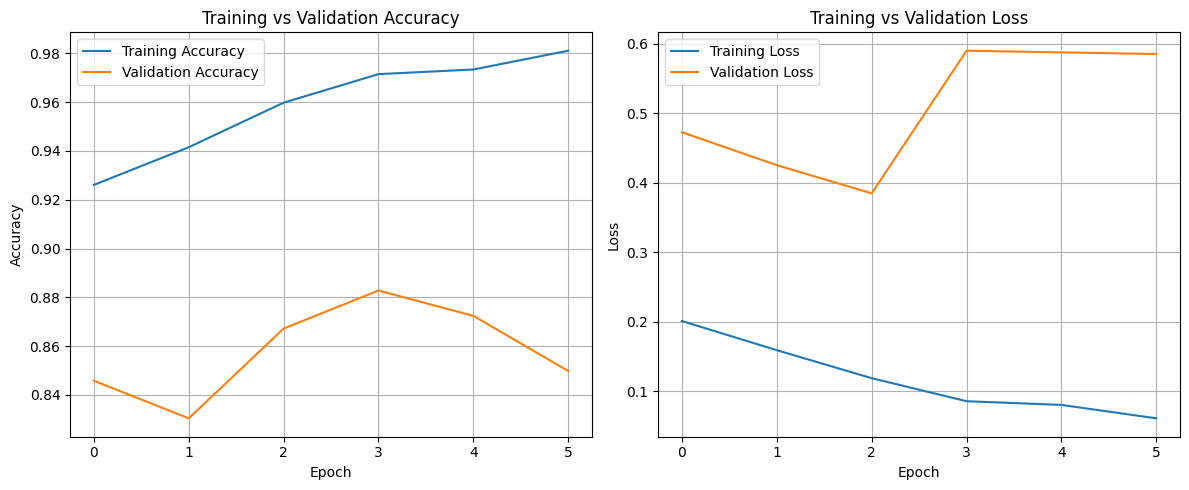

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.81      0.85     12500
    Positive       0.83      0.90      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.85     25000
weighted avg       0.86      0.86      0.85     25000



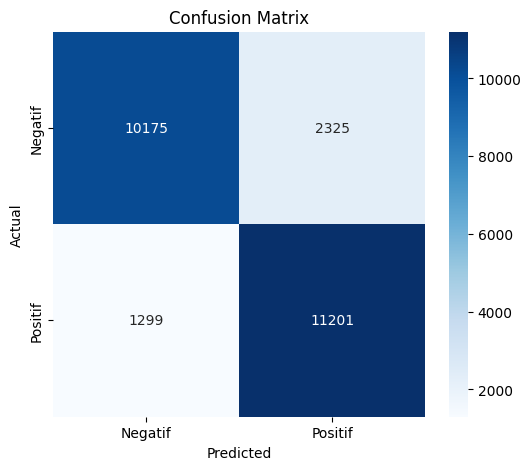

AUC Score: 0.9317


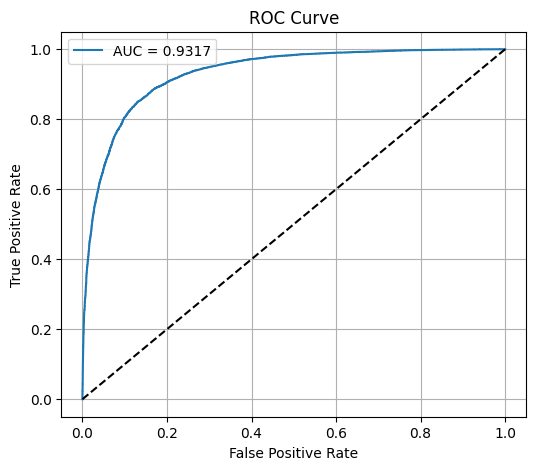

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Prediksi probabilitas & kelas
y_pred_proba = best_model.predict(x_test).ravel()
y_pred = (y_pred_proba >= 0.5).astype(int)

# === Evaluasi Metrik ===
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC & AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

## Persamaan Matematis

Metrik Evaluasi

### Accuracy
$$
\text{Accuracy} = \frac{\text{True Positives + True Negatives}}{\text{Total Samples}}
$$

### Precision
$$
\text{Precision} = \frac{TP}{TP + FP}
$$

### Recall
$$
\text{Recall} = \frac{TP}{TP + FN}
$$

### F1-Score
$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

### AUC (Area Under Curve)
Mengukur area di bawah kurva ROC. Semakin besar, semakin baik model membedakan antara kelas.

---

## 📈 ROC Curve
ROC (Receiver Operating Characteristic) menunjukkan trade-off antara True Positive Rate (TPR) dan False Positive Rate (FPR):

- TPR = Recall
- FPR = \( \frac{FP}{FP + TN} \)

Kurva ROC ideal berada di pojok kiri atas (TPR tinggi, FPR rendah).

#Review Toko Baju

## Import Library

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import keras_tuner as kt

## Data Preparation

In [ ]:
# Load dataset
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv"
df = pd.read_csv(url)

df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [ ]:
df.isna().sum()

,0
Unnamed: 0,0
Clothing ID,0
Age,0
Title,3810
Review Text,845
Rating,0
Recommended IND,0
Positive Feedback Count,0
Division Name,14
Department Name,14


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
print(df.columns)

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')


In [ ]:
df.dropna(inplace=True)

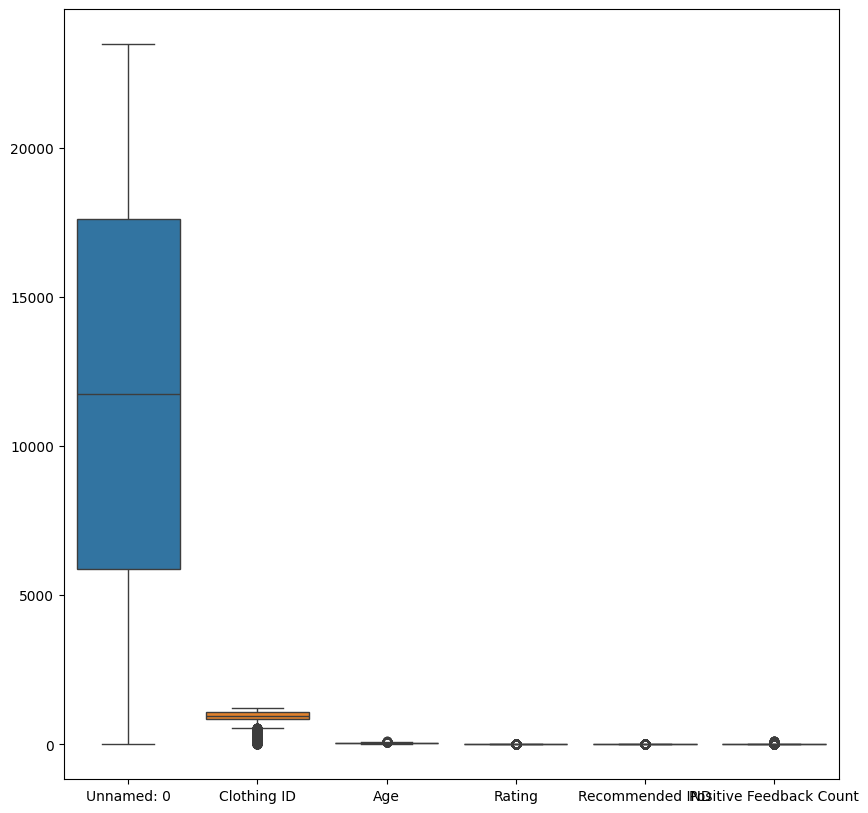

In [ ]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=df)
plt.show()

## Pre-Processing Data

In [ ]:
df = df[['Review Text', 'Rating']].copy()
df.dropna(inplace=True)

def get_sentiment(rating):
    if rating >= 4:
        return 1
    elif rating <= 2:
        return 0
    else:
        return None

df.loc[:, 'Label'] = df['Rating'].apply(get_sentiment)
df.dropna(inplace=True)
df.loc[:, 'Label'] = df['Label'].astype(int)

In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

df['Review Text'] = df['Review Text'].apply(clean_text)
df = df[df['Review Text'].str.strip() != '']

In [ ]:
X = df['Review Text'].values
y = df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tokenizer = Tokenizer(num_words=40000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights = dict(enumerate(class_weights))

## RNN Model

###Recurrent Neural Network (RNN)

Pada RNN, hidden state diperbarui menggunakan input saat ini dan hidden state sebelumnya:

$$
h_t = \tanh(W_{hh} h_{t-1} + W_{xh} x_t + b_h)
$$

Output (jika digunakan secara langsung):

$$
y_t = W_{hy} h_t + b_y
$$

In [ ]:
# Definisikan model dalam bentuk fungsi yang menerima hyperparameters
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))

    # Tuning unit RNN pertama
    model.add(SimpleRNN(units=hp.Int('units_1', min_value=32, max_value=128, step=32), return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.6, step=0.2)))

    # Tuning unit RNN kedua
    model.add(SimpleRNN(units=hp.Int('units_2', min_value=32, max_value=128, step=32), return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.6, step=0.2)))

    # Tuning unit RNN ketiga
    model.add(SimpleRNN(units=hp.Int('units_3', min_value=32, max_value=128, step=32)))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.2, max_value=0.6, step=0.2)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile model dengan learning rate yang dapat dituning
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall(),
                           tf.keras.metrics.AUC(name='auc')])

    return model

### Hyperparameter Tuning

In [ ]:
# Inisialisasi Keras Tuner dengan RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Hanya 5 iterasi
    executions_per_trial=1,  # Hanya satu percobaan untuk setiap kombinasi hyperparameter
    directory='kt_dir',
    project_name='review_sentiment_tuning',
    overwrite=True
)

# Melakukan pencarian hyperparameter
tuner.search(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test), class_weight=class_weights)

# Ambil model terbaik dan simpannya
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('best_model.h5')

# Tampilkan hasil pencarian hyperparameter terbaik
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hyperparameters.values)


Trial 5 Complete [00h 01m 51s]
val_loss: 0.2157038450241089

Best val_loss So Far: 0.2157038450241089
Total elapsed time: 00h 08m 31s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best hyperparameters: {'units_1': 32, 'dropout_1': 0.4, 'units_2': 64, 'dropout_2': 0.4, 'units_3': 96, 'dropout_3': 0.4, 'learning_rate': 7.20463317519233e-05}


### Final Training

In [ ]:
# Muat model terbaik yang sudah disimpan
best_model = tf.keras.models.load_model('best_model.h5')

# Kompilasi ulang model setelah dimuat
best_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_hyperparameters['learning_rate']),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC(name='auc')]
)

# Melakukan final training (fine-tuning) pada model terbaik
history = best_model.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test_pad, y_test),
    class_weight=class_weights,
    verbose=1
)

Epoch 1/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.9169 - auc: 0.9708 - loss: 0.2097 - precision_1: 0.9900 - recall_1: 0.9149 - val_accuracy: 0.8956 - val_auc: 0.9475 - val_loss: 0.2783 - val_precision_1: 0.9764 - val_recall_1: 0.9030
Epoch 2/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.9385 - auc: 0.9830 - loss: 0.1569 - precision_1: 0.9941 - recall_1: 0.9355 - val_accuracy: 0.9230 - val_auc: 0.9443 - val_loss: 0.2434 - val_precision_1: 0.9633 - val_recall_1: 0.9483
Epoch 3/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.9534 - auc: 0.9880 - loss: 0.1241 - precision_1: 0.9949 - recall_1: 0.9520 - val_accuracy: 0.9076 - val_auc: 0.9403 - val_loss: 0.2912 - val_precision_1: 0.9684 - val_recall_1: 0.9248
Epoch 4/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.9634 - auc: 0.9899 - loss: 0.1020 - precision_1: 0.9961 - recall_1: 0.9623 - val_accuracy: 0.9061 - val_auc: 0.9417 - val_loss: 0.3271 - val_precision_1: 0.9723 - val_recall_1: 0.9

### Evaluasi dan Akurasi

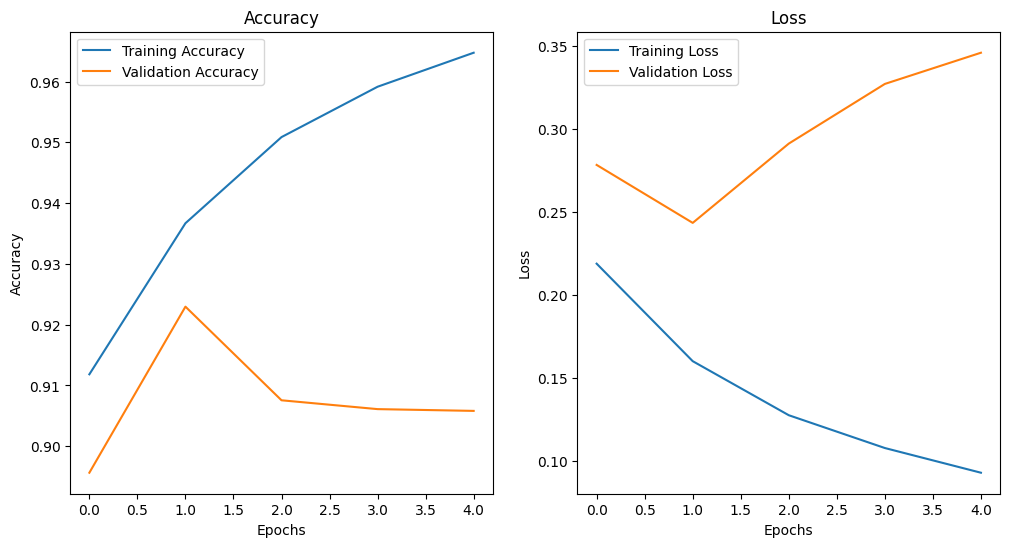

In [ ]:
# Plot training & validation accuracy dan loss
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Menggunakan model terbaik untuk melakukan prediksi
y_pred_prob = best_model.predict(X_test_pad).flatten()  # Gunakan best_model yang sudah dilatih
y_pred = (y_pred_prob > 0.5).astype(int)  # Prediksi label (0 atau 1) berdasarkan threshold 0.5

# Menghitung metrik evaluasi
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

# Menampilkan hasil metrik
print(f"Akurasi: {acc:.4f}")
print(f"Presisi: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
Akurasi: 0.9058
Presisi: 0.9668
Recall: 0.9245
F1-Score: 0.9452
AUC: 0.9436


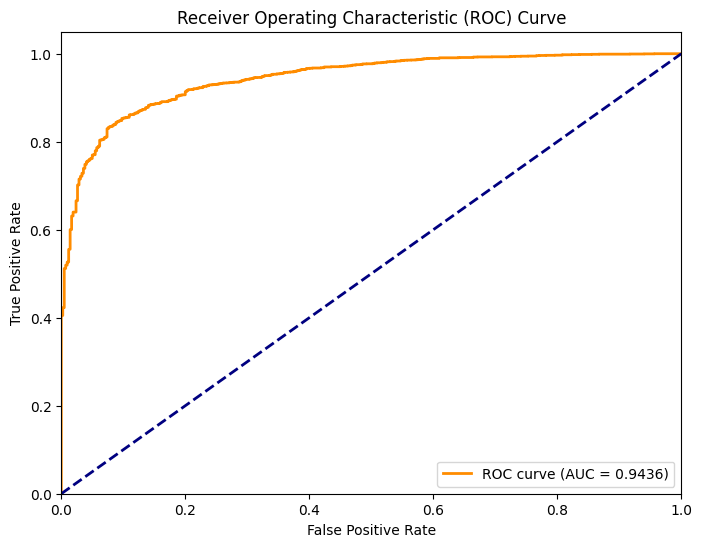

In [ ]:
# Import library yang diperlukan
from sklearn.metrics import roc_curve, auc

# Hitung False Positive Rate (FPR), True Positive Rate (TPR), dan Thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Hitung AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#Deteksi Sarkasme

In [ ]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import keras_tuner as kt
import requests

## Data Preparation

In [ ]:
# Ambil data mentah
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json'
response = requests.get(url)

# Pisahkan setiap baris, lalu decode masing-masing JSON
data = [json.loads(line) for line in response.text.split('\n') if line.strip()]

# Cek sampel
print("Jumlah data:", len(data))
print("Contoh data:", data[0])

Jumlah data: 26709
Contoh data: {'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5', 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers", 'is_sarcastic': 0}


In [ ]:
sentences = [item['headline'] for item in data]
labels = [item['is_sarcastic'] for item in data]

In [ ]:
# Tokenisasi
vocab_size = 10000
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding='post', maxlen=100)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

## Deep RNN dan Hyperparameter Tuning

In [ ]:
def build_model(hp):
    model = tf.keras.Sequential()

    # Embedding layer
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=hp.Int('embed_dim', 32, 128, step=32)
    ))

    # First RNN layer (return_sequences=True untuk menyambung ke RNN berikutnya)
    model.add(tf.keras.layers.SimpleRNN(
        units=hp.Int('rnn_units_1', 32, 128, step=32),
        dropout=hp.Choice('dropout_rate_1', [0.2, 0.3, 0.5]),
        return_sequences=True
    ))

    # Second RNN layer (return_sequences=True)
    model.add(tf.keras.layers.SimpleRNN(
        units=hp.Int('rnn_units_2', 32, 128, step=32),
        dropout=hp.Choice('dropout_rate_2', [0.2, 0.3, 0.5]),
        return_sequences=True
    ))

    # Third RNN layer (last one, return_sequences=False)
    model.add(tf.keras.layers.SimpleRNN(
        units=hp.Int('rnn_units_3', 32, 128, step=32),
        dropout=hp.Choice('dropout_rate_3', [0.2, 0.3, 0.5]),
        return_sequences=False
    ))

    # Output layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(hp.Choice('lr', [1e-3, 1e-4])),
        metrics=['accuracy']
    )

    return model


# Tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='sarcasm_rnn_tuner',
    project_name='simple_rnn_tuning'
)

tuner.search(X_train, np.array(y_train), epochs=5, validation_split=0.2)
best_model = tuner.get_best_models(num_models=1)[0]

Trial 5 Complete [00h 05m 55s]
val_accuracy: 0.5706598162651062

Best val_accuracy So Far: 0.8483855724334717
Total elapsed time: 00h 32m 04s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Final Train & Evaluasi

Epoch 1/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 82s 115ms/step - accuracy: 0.9214 - loss: 0.2133 - val_accuracy: 0.8579 - val_loss: 0.3826
Epoch 2/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 71s 107ms/step - accuracy: 0.9384 - loss: 0.1726 - val_accuracy: 0.8581 - val_loss: 0.3933
Epoch 3/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 83s 108ms/step - accuracy: 0.9536 - loss: 0.1310 - val_accuracy: 0.8557 - val_loss: 0.4393
Epoch 4/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 72s 108ms/step - accuracy: 0.9625 - loss: 0.1075 - val_accuracy: 0.8551 - val_loss: 0.4605
Epoch 5/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 81s 107ms/step - accuracy: 0.9689 - loss: 0.0893 - val_accuracy: 0.8557 - val_loss: 0.4724
Epoch 6/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 72s 108ms/step - accuracy: 0.9748 - loss: 0.0732 - val_accuracy: 0.8538 - val_loss: 0.5171
Epoch 7/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 81s 107ms/step - accuracy: 0.9777 - loss: 0.0651 - val_accuracy: 0.8506 - val_loss: 0.5092
Epoch 8/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 81s 105ms/step - accuracy: 0.9841 - loss: 0

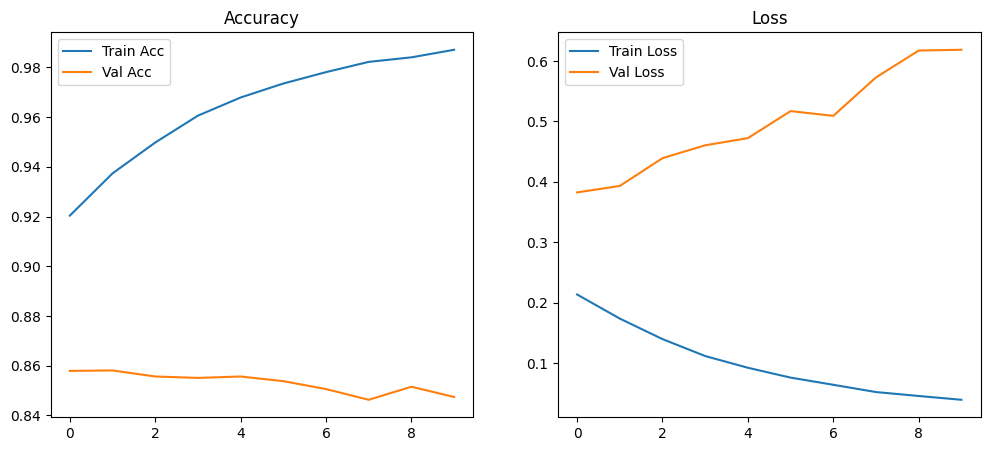

In [ ]:
history = best_model.fit(X_train, np.array(y_train), epochs=10, validation_data=(X_test, np.array(y_test)))

# Visualisasi Akurasi dan Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.show()

167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step
Akurasi  : 0.8474
Presisi  : 0.8270
Recall   : 0.8252
F1-Score : 0.8261
AUC      : 0.9219


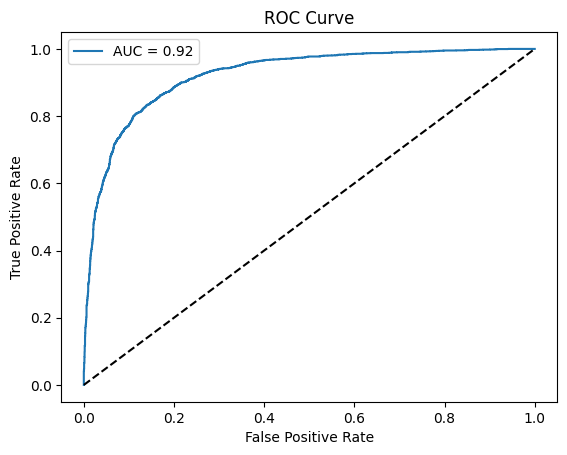

In [ ]:
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"Akurasi  : {acc:.4f}")
print(f"Presisi  : {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()